In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import argparse
import os
from tqdm import tqdm
import time
import math

from net.network import AttentionNet, SelfAttention, vgg_reverse, vgg
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--dataset_dir', type=str, default='../style-transfer-with-style-attention/datasets/content_set/val2014',
                    help='Directory path to a batch of content images')
parser.add_argument('--vgg_model', type=str, default='./models/vgg/vgg_normalised.pth')

# training options
parser.add_argument('--save_dir', default='./models/attention_training',
                    help='Directory to save the model')
parser.add_argument('--log_dir', default='./logs',
                    help='Directory to save the log')
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('--lr_decay', type=float, default=5e-5)
parser.add_argument('--max_iter', type=int, default=80000)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--n_threads', type=int, default=2)
parser.add_argument('--save_model_interval', type=int, default=100)
parser.add_argument('--start_iter', type=float, default=80000)
parser.add_argument('--seperate', type=bool, default=False)
args = parser.parse_args('')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [4]:
# transforms.Normalize((0, 0, 0), (1/255.0, 1/255.0, 1/255.0))
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

train_set = FlatFolderDataset(args.dataset_dir, data_transforms['train'])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=args.batch_size,
    shuffle=True, num_workers=args.n_threads)
train_iter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


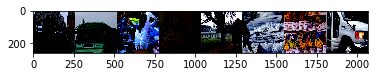

In [5]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [6]:
def get_optimizer(model, seperate):
    for param in model.encode.parameters():
        param.requires_grad = False
    if seperate == True:
        optimizer = torch.optim.Adam([
            {'params': model.self_attn_content.parameters()},
            {'params': model.self_attn_style.parameters()},
            {'params': model.content_decode.parameters()},
            {'params': model.style_decode.parameters()},
        ], lr=args.lr)
    else:
        optimizer = torch.optim.Adam([
            {'params': model.decode.parameters()},
            {'params': model.self_attn.parameters()},
        ], lr=args.lr)
    return optimizer

def state_to_device(parameter, device):
    state_dict = parameter.state_dict()
    for key in state_dict.keys():
        state_dict[key] = state_dict[key].to(device)
    parameter.cuda()
        
encoder = vgg
encoder.load_state_dict(torch.load(args.vgg_model))
state_to_device(encoder, device)

decoder = vgg_reverse
attn = SelfAttention()
if(args.start_iter > 0):
    decoder = vgg_reverse
    decoder.load_state_dict(torch.load(args.save_dir + '/decoder_iter_' + str(args.start_iter) + '.pth'))
    state_to_device(decoder, device)
    
    attn = SelfAttention()
    attn.load_state_dict(torch.load(args.save_dir + '/attention_kernel_iter_' + str(args.start_iter) + '.pth'))
    state_to_device(attn, device)
    
    model = AttentionNet(attn=attn, encoder = encoder, decoder = decoder)
    optimizer = get_optimizer(model, args.seperate)
    optimizer.load_state_dict(torch.load(args.save_dir + '/optimizer_iter_' + str(args.start_iter) + '.pth'))
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
else:
    model = AttentionNet(attn=attn, encoder = encoder, decoder = decoder)
    optimizer = get_optimizer(model, args.seperate)

model.to(device)   
loss_seq = {'total': [], 'construct': [], 'percept': [], 'tv': [], 'attn': []}

FileNotFoundError: [Errno 2] No such file or directory: './models/attention_training/decoder_iter_70800.pth'

In [7]:
def lastest_arverage_value(values, length=100):
    if len(values) < length:
        length = len(values)
    return sum(values[-length:])/length

def adjust_learning_rate(optimizer, iteration_count):
    """Imitating the original implementation"""
    lr = args.lr / (1.0 + args.lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
reload_period = len(train_loader.dataset) / args.batch_size
reload_period = math.floor(reload_period)
for i in tqdm(range(args.start_iter, args.max_iter)):
    adjust_learning_rate(optimizer, iteration_count=i)
    
    if (i - args.start_iter)%reload_period == 0:
        train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=args.batch_size,
            shuffle=True, num_workers=args.n_threads)
        train_iter = iter(train_loader)
        
    if args.seperate == False:
        content_images = next(train_iter).to(device)
        losses, _, _ = model(content_images)
        
    total_loss = losses['total']
    
    for name, vals in loss_seq.items():
        loss_seq[name].append(losses[name].item())
        
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (i + 1) % args.save_model_interval == 0 or (i + 1) == args.max_iter:
        print("%s: Iteration: [%d/%d]\tRecon Loss: %2.4f\tPercept Loss: %2.4f\tTV Loss: %2.4f\tAttn Loss: %2.4f\tTotal: %2.4f"%(time.ctime(),i+1, 
                args.max_iter, lastest_arverage_value(loss_seq['construct']), lastest_arverage_value(loss_seq['percept']), 
                lastest_arverage_value(loss_seq['tv']), lastest_arverage_value(loss_seq['attn']), lastest_arverage_value(loss_seq['total'])))
        if args.seperate == False:
            state_dict = model.decode.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/decoder_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = model.self_attn.state_dict()
            for key in state_dict.keys():
                state_dict[key] = state_dict[key].to(torch.device('cpu'))
            torch.save(state_dict,
                       '{:s}/attention_kernel_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
            state_dict = optimizer.state_dict()
            torch.save(state_dict,
                       '{:s}/optimizer_iter_{:d}.pth'.format(args.save_dir,
                                                               i + 1))
        else:
            pass
    
    

  1%|          | 99/9200 [01:16<1:55:44,  1.31it/s]

Mon Aug  3 00:12:32 2020: Iteration: [70900/80000]	Recon Loss: 294.0730	Percept Loss: 236735.4209	TV Loss: 12.2015	Attn Loss: 8690.5203	Total: 291941.2883


  2%|▏         | 199/9200 [02:33<1:58:13,  1.27it/s]

Mon Aug  3 00:13:49 2020: Iteration: [71000/80000]	Recon Loss: 283.6727	Percept Loss: 230225.8957	TV Loss: 12.0319	Attn Loss: 9072.9688	Total: 287620.7545


  3%|▎         | 299/9200 [03:51<1:55:24,  1.29it/s]

Mon Aug  3 00:15:08 2020: Iteration: [71100/80000]	Recon Loss: 267.8355	Percept Loss: 217019.6193	TV Loss: 11.7118	Attn Loss: 8935.8019	Total: 273429.9042


  4%|▍         | 399/9200 [05:10<1:55:51,  1.27it/s]

Mon Aug  3 00:16:27 2020: Iteration: [71200/80000]	Recon Loss: 293.5013	Percept Loss: 236105.0287	TV Loss: 12.2524	Attn Loss: 10751.7664	Total: 303673.1653


  5%|▌         | 499/9200 [06:29<1:52:49,  1.29it/s]

Mon Aug  3 00:17:46 2020: Iteration: [71300/80000]	Recon Loss: 284.2550	Percept Loss: 229665.3699	TV Loss: 12.1040	Attn Loss: 9431.5593	Total: 289218.3167


  7%|▋         | 599/9200 [07:49<1:53:43,  1.26it/s]

Mon Aug  3 00:19:05 2020: Iteration: [71400/80000]	Recon Loss: 280.7859	Percept Loss: 226680.6420	TV Loss: 11.8717	Attn Loss: 8618.9861	Total: 281321.1353


  8%|▊         | 699/9200 [09:07<1:51:20,  1.27it/s]

Mon Aug  3 00:20:24 2020: Iteration: [71500/80000]	Recon Loss: 288.6742	Percept Loss: 233446.3445	TV Loss: 12.2966	Attn Loss: 8241.4743	Total: 285904.8992


  9%|▊         | 799/9200 [10:26<1:49:29,  1.28it/s]

Mon Aug  3 00:21:43 2020: Iteration: [71600/80000]	Recon Loss: 286.3695	Percept Loss: 228766.4946	TV Loss: 11.9661	Attn Loss: 9648.6544	Total: 289641.7773


 10%|▉         | 899/9200 [11:46<1:52:17,  1.23it/s]

Mon Aug  3 00:23:02 2020: Iteration: [71700/80000]	Recon Loss: 283.9533	Percept Loss: 229395.1613	TV Loss: 12.1001	Attn Loss: 9398.2358	Total: 288745.1083


 11%|█         | 999/9200 [13:06<1:48:34,  1.26it/s]

Mon Aug  3 00:24:22 2020: Iteration: [71800/80000]	Recon Loss: 277.1597	Percept Loss: 224637.6092	TV Loss: 12.0206	Attn Loss: 8956.9176	Total: 281270.9178


 12%|█▏        | 1099/9200 [14:25<1:48:24,  1.25it/s]

Mon Aug  3 00:25:42 2020: Iteration: [71900/80000]	Recon Loss: 286.6429	Percept Loss: 230673.2660	TV Loss: 11.9548	Attn Loss: 8591.9006	Total: 285210.6466


 13%|█▎        | 1199/9200 [15:45<1:45:22,  1.27it/s]

Mon Aug  3 00:27:01 2020: Iteration: [72000/80000]	Recon Loss: 293.6105	Percept Loss: 237471.9120	TV Loss: 12.2518	Attn Loss: 7958.5605	Total: 288281.8995


 14%|█▍        | 1299/9200 [17:04<1:44:02,  1.27it/s]

Mon Aug  3 00:28:21 2020: Iteration: [72100/80000]	Recon Loss: 289.7584	Percept Loss: 233016.5187	TV Loss: 12.2283	Attn Loss: 8331.8130	Total: 286027.2648


 15%|█▌        | 1399/9200 [18:24<1:44:35,  1.24it/s]

Mon Aug  3 00:29:41 2020: Iteration: [72200/80000]	Recon Loss: 291.5963	Percept Loss: 234100.0683	TV Loss: 12.0865	Attn Loss: 9341.0529	Total: 293183.2141


 16%|█▋        | 1499/9200 [19:44<1:41:03,  1.27it/s]

Mon Aug  3 00:31:01 2020: Iteration: [72300/80000]	Recon Loss: 277.1012	Percept Loss: 221323.7066	TV Loss: 11.6979	Attn Loss: 9201.0108	Total: 279417.7633


 17%|█▋        | 1599/9200 [21:04<1:41:37,  1.25it/s]

Mon Aug  3 00:32:21 2020: Iteration: [72400/80000]	Recon Loss: 296.6711	Percept Loss: 236103.5716	TV Loss: 12.1949	Attn Loss: 9418.3912	Total: 295702.5802


 18%|█▊        | 1699/9200 [22:24<1:41:41,  1.23it/s]

Mon Aug  3 00:33:41 2020: Iteration: [72500/80000]	Recon Loss: 286.5670	Percept Loss: 231901.2252	TV Loss: 12.2653	Attn Loss: 8675.4747	Total: 286942.3972


 20%|█▉        | 1799/9200 [23:44<1:36:55,  1.27it/s]

Mon Aug  3 00:35:01 2020: Iteration: [72600/80000]	Recon Loss: 287.5240	Percept Loss: 230558.9020	TV Loss: 11.9946	Attn Loss: 9261.8379	Total: 289125.1147


 21%|██        | 1899/9200 [25:03<1:35:34,  1.27it/s]

Mon Aug  3 00:36:20 2020: Iteration: [72700/80000]	Recon Loss: 290.6319	Percept Loss: 233344.0613	TV Loss: 12.0654	Attn Loss: 8839.0573	Total: 289405.3778


 22%|██▏       | 1999/9200 [26:22<1:34:37,  1.27it/s]

Mon Aug  3 00:37:39 2020: Iteration: [72800/80000]	Recon Loss: 277.1524	Percept Loss: 223090.7709	TV Loss: 11.7901	Attn Loss: 8629.0998	Total: 277754.7950


 23%|██▎       | 2099/9200 [27:41<1:34:23,  1.25it/s]

Mon Aug  3 00:38:58 2020: Iteration: [72900/80000]	Recon Loss: 283.5745	Percept Loss: 229405.2417	TV Loss: 12.0337	Attn Loss: 8792.0094	Total: 285113.3787


 24%|██▍       | 2199/9200 [29:00<1:32:19,  1.26it/s]

Mon Aug  3 00:40:17 2020: Iteration: [73000/80000]	Recon Loss: 302.9371	Percept Loss: 239919.5761	TV Loss: 12.2691	Attn Loss: 9229.6286	Total: 298449.4091


 25%|██▍       | 2299/9200 [30:19<1:30:49,  1.27it/s]

Mon Aug  3 00:41:36 2020: Iteration: [73100/80000]	Recon Loss: 292.4543	Percept Loss: 234695.9966	TV Loss: 12.3114	Attn Loss: 8623.0500	Total: 289481.9527


 26%|██▌       | 2399/9200 [31:39<1:30:00,  1.26it/s]

Mon Aug  3 00:42:55 2020: Iteration: [73200/80000]	Recon Loss: 319.1496	Percept Loss: 254719.4864	TV Loss: 12.7504	Attn Loss: 8896.0140	Total: 311414.5711


 27%|██▋       | 2499/9200 [32:58<1:28:14,  1.27it/s]

Mon Aug  3 00:44:15 2020: Iteration: [73300/80000]	Recon Loss: 284.9859	Percept Loss: 227441.8675	TV Loss: 11.7658	Attn Loss: 8298.9777	Total: 280203.2467


 28%|██▊       | 2599/9200 [34:18<1:26:38,  1.27it/s]

Mon Aug  3 00:45:35 2020: Iteration: [73400/80000]	Recon Loss: 289.0120	Percept Loss: 232182.5525	TV Loss: 12.0600	Attn Loss: 8898.1300	Total: 288582.0528


 29%|██▉       | 2699/9200 [35:38<1:26:03,  1.26it/s]

Mon Aug  3 00:46:55 2020: Iteration: [73500/80000]	Recon Loss: 285.9458	Percept Loss: 230326.3883	TV Loss: 12.1126	Attn Loss: 8200.2734	Total: 282508.6133


 30%|███       | 2799/9200 [36:58<1:26:18,  1.24it/s]

Mon Aug  3 00:48:15 2020: Iteration: [73600/80000]	Recon Loss: 282.1007	Percept Loss: 226568.1397	TV Loss: 11.9214	Attn Loss: 8535.0187	Total: 280718.4705


 32%|███▏      | 2899/9200 [38:18<1:24:41,  1.24it/s]

Mon Aug  3 00:49:35 2020: Iteration: [73700/80000]	Recon Loss: 281.5363	Percept Loss: 226398.7817	TV Loss: 12.0270	Attn Loss: 8347.1878	Total: 279417.5408


 33%|███▎      | 2999/9200 [39:38<1:23:32,  1.24it/s]

Mon Aug  3 00:50:55 2020: Iteration: [73800/80000]	Recon Loss: 277.7035	Percept Loss: 223298.1091	TV Loss: 11.8148	Attn Loss: 7937.0408	Total: 273815.5355


 34%|███▎      | 3099/9200 [40:59<1:21:28,  1.25it/s]

Mon Aug  3 00:52:15 2020: Iteration: [73900/80000]	Recon Loss: 286.0122	Percept Loss: 229586.0240	TV Loss: 12.1602	Attn Loss: 8208.8448	Total: 281820.8194


 35%|███▍      | 3199/9200 [42:18<1:18:56,  1.27it/s]

Mon Aug  3 00:53:35 2020: Iteration: [74000/80000]	Recon Loss: 272.4797	Percept Loss: 220400.2983	TV Loss: 11.8352	Attn Loss: 8743.1353	Total: 275702.2587


 36%|███▌      | 3299/9200 [43:37<1:16:50,  1.28it/s]

Mon Aug  3 00:54:54 2020: Iteration: [74100/80000]	Recon Loss: 269.6581	Percept Loss: 219965.5480	TV Loss: 11.7935	Attn Loss: 8495.7759	Total: 273754.7191


 37%|███▋      | 3399/9200 [44:56<1:15:52,  1.27it/s]

Mon Aug  3 00:56:13 2020: Iteration: [74200/80000]	Recon Loss: 281.5917	Percept Loss: 229338.7937	TV Loss: 12.0873	Attn Loss: 8951.7658	Total: 285986.1781


 38%|███▊      | 3499/9200 [46:15<1:14:10,  1.28it/s]

Mon Aug  3 00:57:32 2020: Iteration: [74300/80000]	Recon Loss: 277.6855	Percept Loss: 224462.0009	TV Loss: 11.9446	Attn Loss: 9048.6751	Total: 281650.3544


 39%|███▉      | 3599/9200 [47:34<1:13:12,  1.28it/s]

Mon Aug  3 00:58:51 2020: Iteration: [74400/80000]	Recon Loss: 273.7991	Percept Loss: 221694.0841	TV Loss: 11.9275	Attn Loss: 8345.2350	Total: 274622.7592


 40%|████      | 3699/9200 [48:54<1:13:43,  1.24it/s]

Mon Aug  3 01:00:10 2020: Iteration: [74500/80000]	Recon Loss: 280.1238	Percept Loss: 225522.2999	TV Loss: 12.0261	Attn Loss: 8557.9855	Total: 279791.7111


 41%|████▏     | 3799/9200 [50:13<1:11:26,  1.26it/s]

Mon Aug  3 01:01:30 2020: Iteration: [74600/80000]	Recon Loss: 280.4014	Percept Loss: 227001.0127	TV Loss: 11.9174	Attn Loss: 8569.6052	Total: 281341.8302


 42%|████▏     | 3899/9200 [51:33<1:10:44,  1.25it/s]

Mon Aug  3 01:02:49 2020: Iteration: [74700/80000]	Recon Loss: 297.6406	Percept Loss: 239097.7119	TV Loss: 12.4181	Attn Loss: 8440.4549	Total: 292841.0291


 43%|████▎     | 3999/9200 [52:53<1:09:18,  1.25it/s]

Mon Aug  3 01:04:10 2020: Iteration: [74800/80000]	Recon Loss: 274.7587	Percept Loss: 220201.8641	TV Loss: 11.6624	Attn Loss: 8681.3040	Total: 275153.9005


 45%|████▍     | 4099/9200 [54:13<1:08:03,  1.25it/s]

Mon Aug  3 01:05:30 2020: Iteration: [74900/80000]	Recon Loss: 285.9315	Percept Loss: 229368.0372	TV Loss: 12.1480	Attn Loss: 9054.6815	Total: 286676.9217


 46%|████▌     | 4199/9200 [55:33<1:07:08,  1.24it/s]

Mon Aug  3 01:06:50 2020: Iteration: [75000/80000]	Recon Loss: 274.2456	Percept Loss: 218299.3578	TV Loss: 11.7542	Attn Loss: 10232.1150	Total: 282552.0466


 47%|████▋     | 4299/9200 [56:54<1:05:44,  1.24it/s]

Mon Aug  3 01:08:10 2020: Iteration: [75100/80000]	Recon Loss: 278.5215	Percept Loss: 224579.5884	TV Loss: 11.9468	Attn Loss: 8644.3583	Total: 279350.4188


 48%|████▊     | 4399/9200 [58:14<1:03:34,  1.26it/s]

Mon Aug  3 01:09:30 2020: Iteration: [75200/80000]	Recon Loss: 269.2595	Percept Loss: 218430.4528	TV Loss: 11.8133	Attn Loss: 8350.1621	Total: 271342.1525


 49%|████▉     | 4499/9200 [59:34<1:03:14,  1.24it/s]

Mon Aug  3 01:10:50 2020: Iteration: [75300/80000]	Recon Loss: 276.2911	Percept Loss: 224985.7181	TV Loss: 11.9832	Attn Loss: 7999.3462	Total: 275864.5377


 50%|████▉     | 4599/9200 [1:00:54<1:00:45,  1.26it/s]

Mon Aug  3 01:12:10 2020: Iteration: [75400/80000]	Recon Loss: 297.5893	Percept Loss: 237509.4060	TV Loss: 12.3811	Attn Loss: 8738.6075	Total: 293040.7589


 51%|█████     | 4699/9200 [1:02:13<58:42,  1.28it/s]  

Mon Aug  3 01:13:29 2020: Iteration: [75500/80000]	Recon Loss: 293.8650	Percept Loss: 237203.9321	TV Loss: 12.2985	Attn Loss: 9426.4533	Total: 296824.2855


 52%|█████▏    | 4799/9200 [1:03:32<58:26,  1.26it/s]  

Mon Aug  3 01:14:49 2020: Iteration: [75600/80000]	Recon Loss: 287.6786	Percept Loss: 228416.1373	TV Loss: 11.9637	Attn Loss: 8312.3593	Total: 281286.7158


 53%|█████▎    | 4899/9200 [1:04:51<57:26,  1.25it/s]  

Mon Aug  3 01:16:08 2020: Iteration: [75700/80000]	Recon Loss: 279.5896	Percept Loss: 225049.3736	TV Loss: 12.0615	Attn Loss: 8519.0445	Total: 279080.1512


 54%|█████▍    | 4999/9200 [1:06:11<54:51,  1.28it/s]  

Mon Aug  3 01:17:27 2020: Iteration: [75800/80000]	Recon Loss: 293.2775	Percept Loss: 235653.4717	TV Loss: 12.3177	Attn Loss: 8032.0310	Total: 286901.6105


 55%|█████▌    | 5099/9200 [1:07:31<54:08,  1.26it/s]  

Mon Aug  3 01:18:47 2020: Iteration: [75900/80000]	Recon Loss: 270.1196	Percept Loss: 217193.7689	TV Loss: 11.8578	Attn Loss: 8418.7669	Total: 270526.1458


 57%|█████▋    | 5199/9200 [1:08:50<53:21,  1.25it/s]  

Mon Aug  3 01:20:07 2020: Iteration: [76000/80000]	Recon Loss: 283.5876	Percept Loss: 228604.0306	TV Loss: 12.1563	Attn Loss: 9103.9199	Total: 286184.9878


 58%|█████▊    | 5299/9200 [1:10:10<53:16,  1.22it/s]  

Mon Aug  3 01:21:27 2020: Iteration: [76100/80000]	Recon Loss: 280.8175	Percept Loss: 226516.1903	TV Loss: 12.0781	Attn Loss: 8640.6487	Total: 281289.0381


 59%|█████▊    | 5399/9200 [1:11:31<51:38,  1.23it/s]

Mon Aug  3 01:22:47 2020: Iteration: [76200/80000]	Recon Loss: 285.2841	Percept Loss: 229940.7657	TV Loss: 12.1483	Attn Loss: 8379.6259	Total: 283192.8469


 60%|█████▉    | 5499/9200 [1:12:51<48:51,  1.26it/s]

Mon Aug  3 01:24:07 2020: Iteration: [76300/80000]	Recon Loss: 284.3821	Percept Loss: 227471.1441	TV Loss: 12.1407	Attn Loss: 8156.0036	Total: 279372.3945


 61%|██████    | 5599/9200 [1:14:11<47:58,  1.25it/s]

Mon Aug  3 01:25:28 2020: Iteration: [76400/80000]	Recon Loss: 288.6312	Percept Loss: 233092.3188	TV Loss: 12.3110	Attn Loss: 8081.0980	Total: 284588.3303


 62%|██████▏   | 5699/9200 [1:15:32<46:24,  1.26it/s]

Mon Aug  3 01:26:48 2020: Iteration: [76500/80000]	Recon Loss: 268.7878	Percept Loss: 215739.8238	TV Loss: 11.7274	Attn Loss: 8191.9949	Total: 267696.9448


 63%|██████▎   | 5799/9200 [1:16:52<45:27,  1.25it/s]

Mon Aug  3 01:28:08 2020: Iteration: [76600/80000]	Recon Loss: 289.0804	Percept Loss: 230631.2748	TV Loss: 12.1895	Attn Loss: 9077.1013	Total: 288106.5795


 64%|██████▍   | 5899/9200 [1:18:12<44:42,  1.23it/s]

Mon Aug  3 01:29:29 2020: Iteration: [76700/80000]	Recon Loss: 293.5785	Percept Loss: 237162.1545	TV Loss: 12.2438	Attn Loss: 8280.5386	Total: 289903.6080


 65%|██████▌   | 5999/9200 [1:19:31<41:49,  1.28it/s]

Mon Aug  3 01:30:48 2020: Iteration: [76800/80000]	Recon Loss: 278.9375	Percept Loss: 224395.0352	TV Loss: 12.0130	Attn Loss: 8792.1967	Total: 280057.7214


 66%|██████▋   | 6099/9200 [1:20:51<40:54,  1.26it/s]

Mon Aug  3 01:32:07 2020: Iteration: [76900/80000]	Recon Loss: 284.1089	Percept Loss: 228745.8439	TV Loss: 12.0186	Attn Loss: 8415.5196	Total: 282200.2331


 67%|██████▋   | 6199/9200 [1:22:10<39:26,  1.27it/s]

Mon Aug  3 01:33:26 2020: Iteration: [77000/80000]	Recon Loss: 284.1008	Percept Loss: 228743.2849	TV Loss: 12.1205	Attn Loss: 9191.4483	Total: 286854.1887


 68%|██████▊   | 6299/9200 [1:23:29<38:33,  1.25it/s]

Mon Aug  3 01:34:46 2020: Iteration: [77100/80000]	Recon Loss: 280.2027	Percept Loss: 226483.7203	TV Loss: 11.9738	Attn Loss: 8999.1601	Total: 283400.4473


 70%|██████▉   | 6399/9200 [1:24:49<37:33,  1.24it/s]

Mon Aug  3 01:36:05 2020: Iteration: [77200/80000]	Recon Loss: 288.0507	Percept Loss: 231783.7619	TV Loss: 12.1631	Attn Loss: 8316.1949	Total: 284683.0686


 71%|███████   | 6499/9200 [1:26:08<35:42,  1.26it/s]

Mon Aug  3 01:37:25 2020: Iteration: [77300/80000]	Recon Loss: 285.0854	Percept Loss: 227186.4245	TV Loss: 12.0880	Attn Loss: 11011.2691	Total: 296225.7708


 72%|███████▏  | 6599/9200 [1:27:28<35:16,  1.23it/s]

Mon Aug  3 01:38:45 2020: Iteration: [77400/80000]	Recon Loss: 291.6075	Percept Loss: 234134.8584	TV Loss: 12.1289	Attn Loss: 8619.9652	Total: 288892.0142


 73%|███████▎  | 6699/9200 [1:28:48<33:16,  1.25it/s]

Mon Aug  3 01:40:05 2020: Iteration: [77500/80000]	Recon Loss: 279.8238	Percept Loss: 225304.0153	TV Loss: 11.9865	Attn Loss: 8088.4818	Total: 276753.0086


 74%|███████▍  | 6799/9200 [1:30:08<32:13,  1.24it/s]

Mon Aug  3 01:41:25 2020: Iteration: [77600/80000]	Recon Loss: 281.2695	Percept Loss: 225629.0384	TV Loss: 11.9061	Attn Loss: 8406.0483	Total: 278997.0841


 75%|███████▍  | 6899/9200 [1:31:29<30:22,  1.26it/s]

Mon Aug  3 01:42:45 2020: Iteration: [77700/80000]	Recon Loss: 281.0742	Percept Loss: 226069.0648	TV Loss: 12.0358	Attn Loss: 8598.9853	Total: 280594.0781


 76%|███████▌  | 6999/9200 [1:32:49<28:58,  1.27it/s]

Mon Aug  3 01:44:06 2020: Iteration: [77800/80000]	Recon Loss: 282.2246	Percept Loss: 226493.1129	TV Loss: 12.0745	Attn Loss: 8867.0980	Total: 282638.6927


 77%|███████▋  | 7099/9200 [1:34:09<28:09,  1.24it/s]

Mon Aug  3 01:45:26 2020: Iteration: [77900/80000]	Recon Loss: 273.7743	Percept Loss: 222351.1477	TV Loss: 12.0061	Attn Loss: 7773.9218	Total: 271852.4834


 78%|███████▊  | 7199/9200 [1:35:30<26:57,  1.24it/s]

Mon Aug  3 01:46:46 2020: Iteration: [78000/80000]	Recon Loss: 273.4308	Percept Loss: 219345.4225	TV Loss: 11.7638	Attn Loss: 8888.4964	Total: 275528.3466


 79%|███████▉  | 7299/9200 [1:36:49<24:47,  1.28it/s]

Mon Aug  3 01:48:06 2020: Iteration: [78100/80000]	Recon Loss: 287.1840	Percept Loss: 231688.2637	TV Loss: 12.0964	Attn Loss: 7931.7678	Total: 282271.6744


 80%|████████  | 7399/9200 [1:38:08<23:28,  1.28it/s]

Mon Aug  3 01:49:25 2020: Iteration: [78200/80000]	Recon Loss: 281.8182	Percept Loss: 225035.9020	TV Loss: 12.0482	Attn Loss: 7907.8969	Total: 275421.9473


 82%|████████▏ | 7499/9200 [1:39:27<22:37,  1.25it/s]

Mon Aug  3 01:50:44 2020: Iteration: [78300/80000]	Recon Loss: 282.1979	Percept Loss: 226979.5463	TV Loss: 12.1687	Attn Loss: 7856.3632	Total: 277061.3906


 83%|████████▎ | 7599/9200 [1:40:47<20:54,  1.28it/s]

Mon Aug  3 01:52:03 2020: Iteration: [78400/80000]	Recon Loss: 262.8675	Percept Loss: 213693.6802	TV Loss: 11.6120	Attn Loss: 9181.3161	Total: 271526.3734


 84%|████████▎ | 7699/9200 [1:42:06<19:40,  1.27it/s]

Mon Aug  3 01:53:22 2020: Iteration: [78500/80000]	Recon Loss: 274.4186	Percept Loss: 220779.0073	TV Loss: 11.9256	Attn Loss: 8093.3785	Total: 272202.7208


 85%|████████▍ | 7799/9200 [1:43:25<18:37,  1.25it/s]

Mon Aug  3 01:54:42 2020: Iteration: [78600/80000]	Recon Loss: 286.4564	Percept Loss: 227513.1164	TV Loss: 12.0995	Attn Loss: 8297.6451	Total: 280284.5470


 86%|████████▌ | 7899/9200 [1:44:45<17:05,  1.27it/s]

Mon Aug  3 01:56:01 2020: Iteration: [78700/80000]	Recon Loss: 279.4888	Percept Loss: 226522.3937	TV Loss: 12.0186	Attn Loss: 7714.3657	Total: 275723.6636


 87%|████████▋ | 7999/9200 [1:46:05<16:04,  1.24it/s]

Mon Aug  3 01:57:21 2020: Iteration: [78800/80000]	Recon Loss: 282.6514	Percept Loss: 226312.3151	TV Loss: 11.9309	Attn Loss: 8248.8414	Total: 278751.1880


 88%|████████▊ | 8099/9200 [1:47:25<14:48,  1.24it/s]

Mon Aug  3 01:58:41 2020: Iteration: [78900/80000]	Recon Loss: 272.9911	Percept Loss: 220279.6672	TV Loss: 11.9327	Attn Loss: 7496.0577	Total: 268105.2530


 89%|████████▉ | 8199/9200 [1:48:45<13:16,  1.26it/s]

Mon Aug  3 02:00:02 2020: Iteration: [79000/80000]	Recon Loss: 294.1303	Percept Loss: 237003.8241	TV Loss: 12.2879	Attn Loss: 8089.2231	Total: 288603.3450


 90%|█████████ | 8299/9200 [1:50:05<12:16,  1.22it/s]

Mon Aug  3 02:01:22 2020: Iteration: [79100/80000]	Recon Loss: 279.8867	Percept Loss: 223543.3827	TV Loss: 11.9223	Attn Loss: 8643.2962	Total: 278321.2508


 91%|█████████▏| 8399/9200 [1:51:26<10:53,  1.23it/s]

Mon Aug  3 02:02:43 2020: Iteration: [79200/80000]	Recon Loss: 293.3886	Percept Loss: 234339.7487	TV Loss: 12.1507	Attn Loss: 8667.8261	Total: 289402.0988


 92%|█████████▏| 8499/9200 [1:52:47<09:27,  1.24it/s]

Mon Aug  3 02:04:03 2020: Iteration: [79300/80000]	Recon Loss: 287.4887	Percept Loss: 232141.4459	TV Loss: 12.3218	Attn Loss: 7567.6732	Total: 280545.5909


 93%|█████████▎| 8599/9200 [1:54:07<07:58,  1.26it/s]

Mon Aug  3 02:05:24 2020: Iteration: [79400/80000]	Recon Loss: 288.1889	Percept Loss: 232393.6306	TV Loss: 12.2686	Attn Loss: 7689.5771	Total: 281535.6683


 95%|█████████▍| 8699/9200 [1:55:27<06:34,  1.27it/s]

Mon Aug  3 02:06:44 2020: Iteration: [79500/80000]	Recon Loss: 273.1255	Percept Loss: 220802.6741	TV Loss: 11.7675	Attn Loss: 8283.3661	Total: 273351.7998


 96%|█████████▌| 8799/9200 [1:56:47<05:18,  1.26it/s]

Mon Aug  3 02:08:03 2020: Iteration: [79600/80000]	Recon Loss: 281.8822	Percept Loss: 226710.0627	TV Loss: 12.0761	Attn Loss: 8456.6775	Total: 280389.7131


 97%|█████████▋| 8899/9200 [1:58:06<03:56,  1.27it/s]

Mon Aug  3 02:09:22 2020: Iteration: [79700/80000]	Recon Loss: 270.9543	Percept Loss: 217334.3424	TV Loss: 11.7172	Attn Loss: 7889.6209	Total: 267498.7825


 98%|█████████▊| 8999/9200 [1:59:25<02:38,  1.27it/s]

Mon Aug  3 02:10:41 2020: Iteration: [79800/80000]	Recon Loss: 269.4129	Percept Loss: 218108.4173	TV Loss: 11.8681	Attn Loss: 7484.8564	Total: 265830.3656


 99%|█████████▉| 9099/9200 [2:00:44<01:19,  1.27it/s]

Mon Aug  3 02:12:01 2020: Iteration: [79900/80000]	Recon Loss: 276.5195	Percept Loss: 223788.8544	TV Loss: 12.0192	Attn Loss: 8886.6239	Total: 279993.9845


100%|█████████▉| 9199/9200 [2:02:04<00:00,  1.25it/s]

Mon Aug  3 02:13:20 2020: Iteration: [80000/80000]	Recon Loss: 283.5040	Percept Loss: 229549.5071	TV Loss: 12.0960	Attn Loss: 8716.6436	Total: 284805.3691


100%|██████████| 9200/9200 [2:02:05<00:00,  1.26it/s]


In [9]:
train_iter = iter(train_loader)
content_images = next(train_iter).to(device)
losses, recon_images, attn_map = model(content_images)
print(recon_images.size())
print(attn_map.size())

torch.Size([8, 3, 256, 256])
torch.Size([8, 512, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


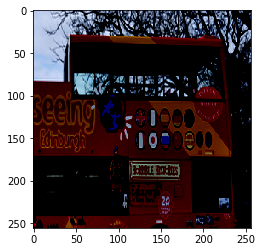

In [10]:
imshow(torchvision.utils.make_grid(content_images.cpu()[2]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


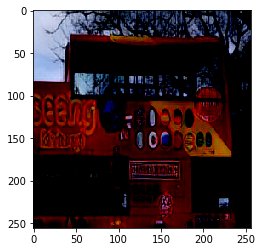

In [11]:
def imshow_recon(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow_recon(torchvision.utils.make_grid(recon_images.cpu()[2]))

torch.Size([8, 32, 32])


(-0.5, 31.5, 31.5, -0.5)

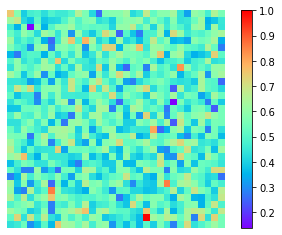

In [12]:
channel_num = attn_map.size()[1]
mean_sal = torch.mean(attn_map, 1, False)
mean_sal_np = mean_sal.cpu().detach().numpy()
mean_sal_np = mean_sal_np - np.min(mean_sal_np)
mean_sal_np = mean_sal_np * 1.0 / np.max(mean_sal_np)
print(mean_sal.size())
plt.imshow(mean_sal_np[2], cmap=cm.get_cmap('rainbow', 1000))
plt.colorbar()
plt.axis('off')